In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial import distance

## Preprocessing & Data Understanding

In [2]:
# preprocessing to get final dataset with transformed values (cf. repo files)

df = pd.read_parquet('Final.parquet')
#print(df.info())


# from initial repo file
# Convert SalesDate_SK to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%Y%m%d')

# Add column for season
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'
    
df['Season'] = df['OrderDate'].dt.month.apply(season_from_month)

# Only keep rows in 2023
df = df[df['OrderDate'].dt.year == 2023]

#print(df.head())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13734196 entries, 0 to 18777102
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   OrderNumber           object        
 1   Company               object        
 2   ArticleID             int64         
 3   OrderDate             datetime64[ns]
 4   CustomerID            object        
 5   RevenueType           object        
 6   PricePackagingUnit    float64       
 7   Quantity              float64       
 8   NetRevenue            float64       
 9   ProductGroup          object        
 10  ProductSubgroup       object        
 11  BusinessArea          object        
 12  Type                  object        
 13  PostalCode            object        
 14  IndustryGroup         object        
 15  SalesChannelCategory  object        
 16  SalesChannel          object        
 17  State                 object        
 18  City                  object        
 19

In [61]:
# create data sample for testing the code
# tbd run final code on total df

data_sample = df.sample(10000)

print(data_sample.head())
#data_sample[["PricePackagingUnit", "Quantity", "NetRevenue"]].describe()

         OrderNumber Company  ArticleID  OrderDate CustomerID RevenueType  \
7584856     46364279   COLER  102680683 2023-12-27      45595    Rechnung   
14868203    93113612  HENNIG  103599764 2023-10-02   10363435    Rechnung   
10177177    92593125  HENNIG  104007803 2023-01-26    5340866  Gutschrift   
5949474     46057575   COLER  103228002 2023-09-22      58888    Rechnung   
12075583    92807523  HENNIG  105171948 2023-05-09    9323597    Rechnung   

          PricePackagingUnit  Quantity  NetRevenue      ProductGroup  \
7584856             0.178010       4.0    0.676702        KAROSSERIE   
14868203            1.963351       1.0    1.905759     SCHMIERSTOFFE   
10177177            0.785340       1.0   -0.831152          ELEKTRIK   
5949474             7.041885       1.0    7.041885            CHEMIE   
12075583            1.047120       4.0    4.204188  ZÜND-/GLÜHANLAGE   

                   ProductSubgroup BusinessArea     Type PostalCode  \
7584856   SONSTIGE KAROSSERIETEIL

In [4]:
# inspect large quantities in entire dataset, dont seem to be outliers
df.loc[df['Quantity'] >= 3000]

,OrderNumber,Company,ArticleID,OrderDate,CustomerID,RevenueType,PricePackagingUnit,Quantity,NetRevenue,ProductGroup,ProductSubgroup,BusinessArea,Type,PostalCode,IndustryGroup,SalesChannelCategory,SalesChannel,State,City,Season
154832,RG13000030786,AAG,104695197,2023-03-07,150366,Rechnung,0.022251,6000.0,133.507853,UMWELT & ENTSORGUNG,UMWELT & ENTSORGUNG WA,WA,Artikel,79110,IND,B2B_Industrial,B2B,Baden-Württemberg,Freiburg im Breisgau,Spring
541770,RG13000110722,AAG,107071501,2023-09-18,155045,Rechnung,0.000000,3100.0,0.000000,PFAND,PFAND IAM,IAM,Service,79110,WKO,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Freiburg im Breisgau,Autumn
569950,RG13000117545,AAG,103608592,2023-10-17,151540,Rechnung,0.451571,10080.0,4551.832461,CHEMIE,SERVICEPRODUKTE & SPRAYS,IAM,Artikel,48155,KOO,B2B_wholesalers,B2B,Nordrhein-Westfalen,Münster,Autumn
638067,RG13000122773,AAG,104695197,2023-10-20,150366,Rechnung,0.022251,6000.0,133.507853,UMWELT & ENTSORGUNG,UMWELT & ENTSORGUNG WA,WA,Artikel,79110,IND,B2B_Industrial,B2B,Baden-Württemberg,Freiburg im Breisgau,Autumn
2711374,45355259,COLER,340371,2023-02-02,67459,Rechnung,0.189791,3375.0,640.543194,SONSTIGES,SONSTIGES IAM,IAM,Artikel,23558,KOO,B2B_wholesalers,B2B,Schleswig-Holstein,Lübeck,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15991131,93234955,HENNIG,102734728,2023-12-01,5338809,Rechnung,0.000000,4000.0,0.000000,WERBUNG,WERBEMITTEL,IAM,Artikel,41238,HCC,B2B_wholesalers,B2B,Nordrhein-Westfalen,Mönchengladbach,Winter
16017782,93242154,HENNIG,112964828,2023-11-22,10479160,Rechnung,1.570681,8000.0,1.570681,HENNIG - keine Angaben vorhanden,HENNIG - keine Angaben vorhanden,IAM,Artikel,53123,ÖFE,B2B_Authorities + Institutions,B2B,Nordrhein-Westfalen,Bonn,Autumn
16126769,93252647,HENNIG,111512956,2023-12-11,10556457,Rechnung,4.319372,3000.0,129.581152,HENNIG - keine Angaben vorhanden,HENNIG - keine Angaben vorhanden,IAM,Artikel,63486,WNF,B2B2C_CV repairers,B2B2C,Hessen,Bruchköbel,Winter
16242763,93266520,HENNIG,104368906,2023-11-30,10435133,Rechnung,0.261780,4320.0,1215.706806,CHEMIE,WINTERARTIKEL,IAM,Artikel,53879,HCC,B2B_wholesalers,B2B,Nordrhein-Westfalen,Euskirchen,Autumn


In [7]:
# check if entries/rows are unique order numbers

print(data_sample["OrderNumber"].nunique()) # 991 out of 1000 rows
data_sample.loc[data_sample['OrderNumber'].duplicated(keep = False)].sort_values('OrderNumber', ascending=False)

# duplicate order numbers indicate that one order can contain multiple different articles/rows in system
# needs to be considered for order counting etc

991


,OrderNumber,Company,ArticleID,OrderDate,CustomerID,RevenueType,PricePackagingUnit,Quantity,NetRevenue,ProductGroup,ProductSubgroup,BusinessArea,Type,PostalCode,IndustryGroup,SalesChannelCategory,SalesChannel,State,City,Season
667289,RG13000135749,AAG,105567541,2023-12-06,147148,Rechnung,0.396597,1.0,0.396597,FILTER,ÖLFILTER,IAM,Artikel,77815,WCC,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Bühl,Winter
679518,RG13000135749,AAG,106746185,2023-12-05,147148,Rechnung,0.850785,1.0,0.850785,FILTER,ÖLFILTER,IAM,Artikel,77815,WCC,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Bühl,Winter
15500872,93186595,HENNIG,102280113,2023-11-10,5342710,Rechnung,1.047120,1.0,1.109948,KAROSSERIE,WISCHBLÄTTER,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
15505622,93186595,HENNIG,106795899,2023-11-07,5342710,Rechnung,0.261780,1.0,0.221204,BREMSE,WARNKONTAKTE,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
15203423,93157176,HENNIG,104260353,2023-10-25,10302944,Rechnung,3.534031,2.0,7.023560,BREMSE,BREMSSCHEIBEN,IAM,Artikel,74391,WKW,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Erligheim,Autumn
15197547,93157176,HENNIG,103903204,2023-10-25,10302944,Rechnung,2.225131,2.0,4.450262,BREMSE,BELÄGE SCHEIBENBREMSE,IAM,Artikel,74391,WKW,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Erligheim,Autumn
14915958,93112452,HENNIG,106842174,2023-10-05,5342710,Rechnung,3.403141,1.0,3.380890,MOTOR,ZAHNRIEMENKITS,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
14869037,93112452,HENNIG,103266256,2023-10-01,5342710,Rechnung,3.272251,2.0,6.578534,BREMSE,BREMSSCHEIBEN,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
13838868,92996381,HENNIG,107040043,2023-08-12,5342710,Rechnung,2.225131,2.0,4.447644,BREMSE,BREMSSCHEIBEN,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Summer
13877129,92996381,HENNIG,105533183,2023-08-10,5342710,Rechnung,1.439791,1.0,1.433246,KAROSSERIE,WISCHBLÄTTER,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Summer


## Share of Revenue per Customer

In [8]:
# total revenue per Kunden_SK (share), cumulated descending values

totalRevenue = df['NetRevenue'].sum()
print(totalRevenue)

result = df.groupby('CustomerID')['NetRevenue'].sum().reset_index()
result['shareOfRevenue'] = (result['NetRevenue']/totalRevenue)*100
result = result.sort_values('shareOfRevenue', ascending=False)
print(result.head())
#print(result['shareOfRevenue'].sum())

result["cumulatedShare"] = np.cumsum(result["shareOfRevenue"])
print(result.head())

72341712.01832461
      CustomerID     NetRevenue  shareOfRevenue
22287    5342710  677079.776178        0.935947
2142    10413532  540707.574607        0.747435
8422      151238  436861.010471        0.603885
35868    9883351  427228.951571        0.590571
13934      35284  396227.252618        0.547716
      CustomerID     NetRevenue  shareOfRevenue  cumulatedShare
22287    5342710  677079.776178        0.935947        0.935947
2142    10413532  540707.574607        0.747435        1.683382
8422      151238  436861.010471        0.603885        2.287267
35868    9883351  427228.951571        0.590571        2.877838
13934      35284  396227.252618        0.547716        3.425554


In [11]:
# insights of revenue distribution

result.describe() # 25% of customers already describe 93 % of total revenue

check = result.loc[result['cumulatedShare'] <= 90]
check.info() # 90 % of revenue are provided by top 7193 customers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7193 entries, 22287 to 24694
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      7193 non-null   object 
 1   NetRevenue      7193 non-null   float64
 2   shareOfRevenue  7193 non-null   float64
 3   cumulatedShare  7193 non-null   float64
dtypes: float64(3), object(1)
memory usage: 281.0+ KB


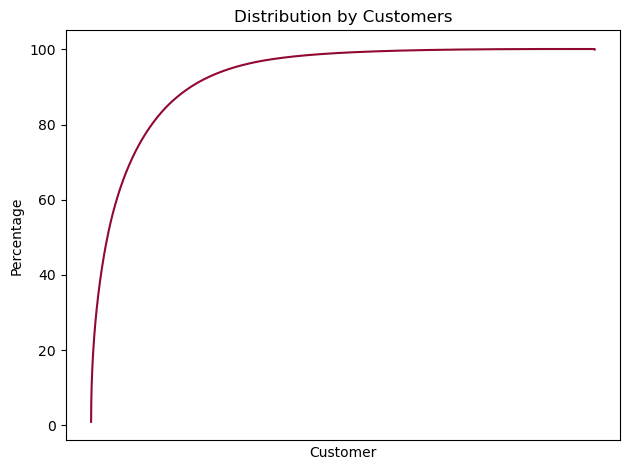

In [12]:
# plot distribution for all customers, note: takes a while

cumulatedplot = plt.plot(
    result['CustomerID'], 
    result["cumulatedShare"], 
    color= (145/255, 8/255, 48/255)
)

# Set axis labels and title
plt.xlabel('Customer')
plt.ylabel('Percentage')
plt.title('Distribution by Customers')

plt.tick_params(labelbottom = False, bottom = False) 
#plt.xticks(visible=False)
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
'''
# other plots for data understanding

### quantity per channel
sns.set_palette(palette="RdGy")
sns.displot(data=data_sample, x = "Quantity", hue = "SalesChannel", kind="kde")
plt.show()

### quantity per type and saleschannel
sns.set_theme(style="whitegrid")
sns.set_palette(palette="RdGy")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
# Show each observation with a scatterplot
sns.stripplot(
    data=data_sample, x="Quantity", y="Type", hue="SalesChannel",
    dodge=True, alpha=.25, zorder=1, legend=False)
# Show the conditional means
sns.pointplot(
    data=data_sample, x="Quantity", y="Type", hue="SalesChannel",
    dodge=.8 - .8 / 3, errorbar=None,
    markers="d", linestyles="none")
# Improve the legend
sns.move_legend(
    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0)

### number of orders per date and channel
sns.histplot(data=df, x="OrderDate", hue = "SalesChannel", bins = 52, kde=True, color = "#852339")
plt.show()

'''

## Feature Selection & Clustering

In [ ]:
# create dataset on customer level containing behavior features: 
# Recency = time since last order, Frequency = number of orders, Monetary = sum of netRevenue
rfm = pd.DataFrame()

# timespan since most recent order per customer
reference_time = pd.Timestamp('2023-12-31')
reference_date = pd.to_datetime(reference_time, format='%Y%m%d')
# Calculate the difference in days from the reference date
data_sample['daysSinceLastOrder'] = (reference_date - data_sample['OrderDate']).dt.days
# Find the most recent order in weeks for each customerID
rfmrec = data_sample.groupby('CustomerID')['daysSinceLastOrder'].min().reset_index()

# count of orders per customer
# tbd count on order level? i.e., count only the unique order numbers?
rfmfreq = data_sample['CustomerID'].value_counts().reset_index()
rfmfreq.columns = ['CustomerID', 'orderCount']

# total revenue per customer
rfmmon = data_sample.groupby('CustomerID')['NetRevenue'].sum().reset_index()
rfmmon.columns = ['CustomerID', 'sumRevenue']

# merge features
rfm1 = pd.merge(rfmrec, rfmfreq, on='CustomerID')
rfm = pd.merge(rfm1, rfmmon, on='CustomerID')
data_sample =data_sample.drop(['daysSinceLastOrder'], axis=1)

# for plotting: exclude outlier values to have better plots, tbd decide how to handle for actual clustering
#rfm.drop(rfm[rfm['orderCount'] >= 1000].index, inplace=True)
#rfm.drop(rfm[rfm['sumRevenue'] >= 10000].index, inplace=True)
#rfm.drop(rfm[rfm['sumRevenue'] <= -1000].index, inplace=True)
#rfm.describe()
rfm.head()
#data_sample.info()


# customers in one cluster behave similarly considering their activities, frequencies... 
# they have a similar value for the company and importance for sales

In [54]:
rfm.loc[rfm['sumRevenue'] <= -1000]

,CustomerID,daysSinceLastOrder,orderCount,sumRevenue
987,10289235,221,1,-1636.125654
10598,43649,234,1,-4730.366492
15203,5345107,54,7,-3338.829843
20107,8185,325,1,-1046.198953
21129,9067168,152,1,-2866.492147
22836,9562669,9,307,-10036.100785


In [56]:
# validate rfm calculations based on one of the entries
print(rfm.info())
#rfm.head()
data_sample.loc[data_sample['CustomerID'] == "10000568"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24223 entries, 0 to 24326
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          24223 non-null  object 
 1   daysSinceLastOrder  24223 non-null  int64  
 2   orderCount          24223 non-null  int64  
 3   sumRevenue          24223 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 946.2+ KB
None


,OrderNumber,Company,ArticleID,OrderDate,CustomerID,RevenueType,PricePackagingUnit,Quantity,NetRevenue,ProductGroup,ProductSubgroup,BusinessArea,Type,PostalCode,IndustryGroup,SalesChannelCategory,SalesChannel,State,City,Season
14121708,93034427,HENNIG,112964828,2023-08-31,10000568,Gutschrift,2.617801,1.0,-2.617801,HENNIG - keine Angaben vorhanden,HENNIG - keine Angaben vorhanden,IAM,Artikel,56179,WKO,B2B2C_LV repairers,B2B2C,Rheinland-Pfalz,Vallendar,Summer
14120657,93034410,HENNIG,112964828,2023-08-31,10000568,Gutschrift,2.617801,1.0,-2.617801,HENNIG - keine Angaben vorhanden,HENNIG - keine Angaben vorhanden,IAM,Artikel,56179,WKO,B2B2C_LV repairers,B2B2C,Rheinland-Pfalz,Vallendar,Summer


In [63]:
# tbd create two datasets for differentiated analyses, decide on features
# 1.: customer level: idea: rfm per customer, location/city (unique per customer?), saleschannel
# ["daysSinceLastOrder", "orderCount", "sumRevenue", BusinessArea", "IndustryGroup", "City", "SalesChannel"] = silhouette score of 0.4
# ["daysSinceLastOrder", "orderCount", "sumRevenue", "BusinessArea", "SalesChannel"] = silhouette score of 0.61
customer_data = data_sample[["CustomerID", "BusinessArea", "SalesChannel"]].drop_duplicates('CustomerID')
customer_df = pd.merge(rfm, customer_data, how='left', on='CustomerID')
print(customer_df.head())

# 2.: item level: idea: season, revenueType, quantity, netrevenue, productgroup, type...
# ["Company", "ArticleID", "RevenueType", "PricePackagingUnit", "Quantity", "NetRevenue", "BusinessArea", "Type", "IndustryGroup", "SalesChannel", "City", "Season"] = silhouette score of 0.15
# ["ArticleID", "PricePackagingUnit", "Quantity", "NetRevenue", "BusinessArea", "Type", "SalesChannel",  "Season"] = silhouette score of 0.38
# ["PricePackagingUnit", "Quantity", "NetRevenue", "BusinessArea", "Type", "SalesChannel",  "Season"] = silhouette score of 0.64
item_data = data_sample.drop(["Company", "OrderNumber", "OrderDate", "CustomerID", "ProductGroup", "ProductSubgroup", "IndustryGroup", "City", "PostalCode", "SalesChannelCategory", "State"], axis=1)
print(item_data.head())

  CustomerID  daysSinceLastOrder  orderCount  sumRevenue BusinessArea  \
0   10001245                 129           4  -16.823298          IAM   
1   10005051                 354           1    1.040576          IAM   
2   10005258                  81           3   11.130890          IAM   
3   10006364                 353           1    6.688482          IAM   
4   10007291                 104           5    9.948953          IAM   

  SalesChannel  
0        B2B2C  
1          B2B  
2        B2B2C  
3        B2B2C  
4          B2B  
          ArticleID RevenueType  PricePackagingUnit  Quantity  NetRevenue  \
7584856   102680683    Rechnung            0.178010       4.0    0.676702   
14868203  103599764    Rechnung            1.963351       1.0    1.905759   
10177177  104007803  Gutschrift            0.785340       1.0   -0.831152   
5949474   103228002    Rechnung            7.041885       1.0    7.041885   
12075583  105171948    Rechnung            1.047120       4.0    4.204188 

In [ ]:
# Scale customer-level features for clustering

# encode cf. repo file test_k-means
encoder = OneHotEncoder(sparse_output=False)
customer_encoded_features = encoder.fit_transform(customer_df[["BusinessArea", "SalesChannel"]])
customer_encoded_df = pd.DataFrame(customer_encoded_features, columns=encoder.get_feature_names_out())
# Reset the indices of all DataFrames before concatenation
customer_df_reset = customer_df.drop(["BusinessArea", "SalesChannel"], axis=1).reset_index(drop=True)
customer_encoded_df_reset = customer_encoded_df.reset_index(drop=True)
# Combine all features
customer_df_encoded = pd.concat([customer_df_reset, customer_encoded_df_reset], axis=1)
customer_df_encoded = customer_df_encoded.drop(["CustomerID"], axis=1)
#print(customer_df_encoded.info())

# scale
scaler = StandardScaler()
scaled_customer = scaler.fit_transform(customer_df_encoded)
customer_scaled = pd.DataFrame(scaled_customer, columns=customer_df_encoded.columns)
print(customer_scaled.head())

In [ ]:
# apply K-Means Clustering with Silhouette Score
customer_tot_withinss = []
customer_cluster_scores = []
ks = list(range(2, 16))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_scaled)
    score = silhouette_score(customer_scaled, clusters)
    customer_cluster_scores.append((k, score))
    print(f"Silhouette Score for {k} clusters: {score}")
    customer_tot_withinss.append(kmeans.inertia_)

# Get best cluster number
customer_best_cluster = max(customer_cluster_scores, key=lambda x: x[1])[0]
print(f"Best customer cluster number based on Silhouette: {customer_best_cluster}")

# plot elbow graph
customer_withinss_df = pd.DataFrame({'k': ks, 'tot_withinss': customer_tot_withinss})
sns.set_style("whitegrid")
sns.lineplot(data=customer_withinss_df, x='k', y='tot_withinss')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Sum-of-Squares (WSS)')
plt.show()


In [ ]:
# visualization
# tbd use PCA to include all features?

customer_k_means_optimum = KMeans(n_clusters=customer_best_cluster, random_state=42)
customer_k_means_optimum.fit_predict(customer_scaled)
customer_scaled['cluster'] = customer_k_means_optimum.labels_
# Create a dictionary to hold the subset DataFrames
cluster_subsets = {}
# Loop through each unique cluster label and create a subset DataFrame
for cluster_num in customer_scaled['cluster'].unique():
    cluster_subsets[cluster_num] = customer_scaled[customer_scaled['cluster'] == cluster_num]   

# plot
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
colors = mpl.colormaps['RdGy'].resampled(customer_best_cluster)

for i in range(customer_best_cluster):
  subset_plot = cluster_subsets[i]
  kplot.scatter3D(subset_plot["orderCount"], subset_plot["daysSinceLastOrder"], subset_plot["sumRevenue"], color = colors(i), label = f'Cluster {i+1}')
  kplot.scatter3D(customer_k_means_optimum.cluster_centers_[i,0], customer_k_means_optimum.cluster_centers_[i,1],customer_k_means_optimum.cluster_centers_[i,2], color = colors(i),edgecolors='black', s = 100, alpha = 0.5)
plt.xlim(customer_scaled['orderCount'].min(), customer_scaled['orderCount'].max())
plt.ylim(customer_scaled['daysSinceLastOrder'].min(), customer_scaled['daysSinceLastOrder'].max())
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
set_xlabel = kplot.set_xlabel('orderCount')
set_ylabel = kplot.set_ylabel('daysSinceLastOrder')
set_zlabel = kplot.set_zlabel('sumRevenue')
plt.title("Kmeans")
plt.show()

In [ ]:
test = customer_k_means_optimum.cluster_centers_
test[:10]

In [ ]:
# Scale item features for clustering

# encode cf. repo file test_k-means
encoder = OneHotEncoder(sparse_output=False)
item_encoded_features = encoder.fit_transform(item_data[['SalesChannel', 'Type', 'BusinessArea', 'Season']])
item_encoded_df = pd.DataFrame(item_encoded_features, columns=encoder.get_feature_names_out())
# Reset the indices of all DataFrames before concatenation
item_df_reset = item_data.drop(['SalesChannel', 'Type', 'BusinessArea', 'RevenueType', 'Season'], axis=1).reset_index(drop=True)
item_encoded_df_reset = item_encoded_df.reset_index(drop=True)
# Combine all features
item_df_encoded = pd.concat([item_df_reset, item_encoded_df_reset], axis=1)
#print(item_df_encoded.info())

# scale
scaler = StandardScaler()
scaled_item = scaler.fit_transform(item_df_encoded)
item_scaled = pd.DataFrame(scaled_item, columns=item_df_encoded.columns)
print(item_df_encoded.head())

In [ ]:
# apply K-Means Clustering with Silhouette Score
item_tot_withinss = []
item_cluster_scores = []
ks = list(range(2, 21))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(item_scaled)
    score = silhouette_score(item_scaled, clusters)
    item_cluster_scores.append((k, score))
    print(f"Silhouette Score for {k} clusters: {score}")
    item_tot_withinss.append(kmeans.inertia_)
    
# Get best cluster number
item_best_cluster = max(item_cluster_scores, key=lambda x: x[1])[0]
print(f"Best item cluster number based on Silhouette: {item_best_cluster}")
    
item_withinss_df = pd.DataFrame({'k': ks, 'tot_withinss': item_tot_withinss})
sns.set_style("whitegrid")
sns.lineplot(data=item_withinss_df, x='k', y='tot_withinss')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Sum-of-Squares (WSS)')
plt.show()

In [ ]:
# visualization
# tbd use PCA to include all features?

#customer_best_cluster = 10
item_k_means_optimum = KMeans(n_clusters=item_best_cluster, random_state=42)
item_k_means_optimum.fit_predict(item_scaled)
item_scaled['cluster'] = item_k_means_optimum.labels_
# Create a dictionary to hold the subset DataFrames
cluster_subsets = {}
# Loop through each unique cluster label and create a subset DataFrame
for cluster_num in item_scaled['cluster'].unique():
    cluster_subsets[cluster_num] = item_scaled[item_scaled['cluster'] == cluster_num]   

# plot
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
colors = mpl.colormaps['RdGy'].resampled(item_best_cluster)

for i in range(item_best_cluster):
  subset_plot = cluster_subsets[i]
  kplot.scatter3D(subset_plot["PricePackagingUnit"], subset_plot["NetRevenue"], subset_plot["Quantity"], color = colors(i), label = f'Cluster {i+1}')
  kplot.scatter3D(item_k_means_optimum.cluster_centers_[i,0], item_k_means_optimum.cluster_centers_[i,1],item_k_means_optimum.cluster_centers_[i,2], color = colors(i),edgecolors='black', s = 100, alpha = 0.5)
plt.xlim(item_scaled['PricePackagingUnit'].min(), item_scaled['PricePackagingUnit'].max())
plt.ylim(item_scaled['NetRevenue'].min(), item_scaled['NetRevenue'].max())
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
set_xlabel = kplot.set_xlabel('PricePackagingUnit')
set_ylabel = kplot.set_ylabel('NetRevenue')
set_zlabel = kplot.set_zlabel('Quantity')
plt.title("Kmeans")
plt.show()

In [39]:
# reduce dimensionality of rfm features
# tbd decide whether to use that for clustering or plotting
pca = PCA(n_components=15)
pca.fit(item_scaled)
print(pca.explained_variance_ratio_)

# correlation matrix of rfm features
matrix = item_scaled.corr()
print("Correlation matrix is : ")
print(matrix)

[0.11122609 0.08642162 0.06701703 0.06172303 0.05637545 0.05598893
 0.05420709 0.04889706 0.0460519  0.04512186 0.04331107 0.04171642
 0.04165334 0.04132398 0.04120308]


In [ ]:
# tbd test different parameters for k-means
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

# option 1
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
# option 2
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
# option 3
pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)

In [19]:
# original code from repo, adapted to generic function for subsets

def encodeDataset(column, value):
    df_small = data_sample
    df_small['CustomerID'] = df_small['CustomerID'].astype(int)

# choose subset to focus on (saleschannel, company, season)
    df_small = df_small[df_small[column] == value]

# High cardinality features
    high_card_cols = ['City', 'ProductGroup', 'ProductSubgroup', 'PostalCode']
    high_card_data = df_small[high_card_cols].astype(str).values.tolist()
    hasher = FeatureHasher(n_features=10, input_type='string')
    hashed_features = hasher.fit_transform(high_card_data)

# Convert hashed features to a DataFrame
    hashed_features_df = pd.DataFrame(hashed_features.toarray(), columns=[f'hash_{i}' for i in range(10)])

# One-hot encoding for other categorical variables
    encoder = OneHotEncoder(sparse_output=False)
    encoded_features = encoder.fit_transform(df_small[['SalesChannel', 'IndustryGroup', 'Type', 'BusinessArea', 'Company', 'RevenueType']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Reset the indices of all DataFrames before concatenation
    df_small_reset = df_small.drop(['City', 'ProductGroup', 'ProductSubgroup', 'PostalCode', 'SalesChannel', 'IndustryGroup', 'Type', 'BusinessArea', 'Company', 'RevenueType'], axis=1).reset_index(drop=True)
    hashed_features_df_reset = hashed_features_df.reset_index(drop=True)
    encoded_df_reset = encoded_df.reset_index(drop=True)

# Combine all features
    df2 = pd.concat([df_small_reset, hashed_features_df_reset, encoded_df_reset], axis=1)
    #print(df2.info())
    return df2

In [20]:
# correlation analysis for subset-wise differentiation

# correlation matrix
dataset = encodeDataset("SalesChannel", "B2B") # choose SalesChannel, Company etc. for differentiation
matrix_encoded = dataset.corr()
print("Correlation matrix is : ")
print(matrix_encoded)

# insights: e.g. Company = Hennig : only Type_Artikel, 
# Company = AAG, Type_Artikel& Service,
# SalesChannel = B2B: correlation quantity & coler, netrevenue & aag

Correlation matrix is : 
                        ArticleID  CustomerID  PricePackagingUnit  Quantity  \
ArticleID                1.000000    0.008000            0.083650  0.010829   
CustomerID               0.008000    1.000000           -0.050073 -0.110586   
PricePackagingUnit       0.083650   -0.050073            1.000000 -0.061177   
Quantity                 0.010829   -0.110586           -0.061177  1.000000   
NetRevenue               0.017292   -0.138049            0.489038  0.554383   
hash_0                   0.004023    0.110067           -0.057338 -0.012631   
hash_1                  -0.429709   -0.021080           -0.039204  0.027301   
hash_2                  -0.001733   -0.035127            0.085191 -0.017090   
hash_3                   0.034396    0.101901            0.111311 -0.036645   
hash_4                   0.010491   -0.016766           -0.142225 -0.021487   
hash_5                  -0.048220    0.048375           -0.043443 -0.020239   
hash_6                  -0.

C:\Users\zoini\AppData\Local\Temp\ipykernel_18380\1927198159.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_encoded = dataset.corr()
